In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, utils, datasets
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 1. Load and preprocess CIFAR-10
NUM_CLASSES = 10

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Resize images to 71x71 because Xception expects input size >=71x71
import tensorflow as tf
x_train = tf.image.resize(x_train, (75, 75))
x_test = tf.image.resize(x_test, (75, 75))

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

In [3]:
# 2. Build the model using Xception
base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(75, 75, 3),
    pooling="avg"
)
base_model.trainable = False  # Freeze base model initially

input_layer = layers.Input(shape=(75, 75, 3))
x = base_model(input_layer, training=False)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(input_layer, output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,388,594 (81.59 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [4]:
# 3. Compile the model
opt = optimizers.Adam(learning_rate=0.001)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

In [5]:
# 4. Train the model (first train top layers)
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=15,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    shuffle=True,
)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.6106 - loss: 1.1866 - val_accuracy: 0.7134 - val_loss: 0.8241
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 38ms/step - accuracy: 0.7162 - loss: 0.8357 - val_accuracy: 0.7277 - val_loss: 0.7847
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.7331 - loss: 0.7691 - val_accuracy: 0.7389 - val_loss: 0.7531
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.7526 - loss: 0.7127 - val_accuracy: 0.7434 - val_loss: 0.7501
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.7643 - loss: 0.6756 - val_accuracy: 0.7438 - val_loss: 0.7405
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.7725 - loss: 0.6495 - val_accuracy: 0.7463 - val_loss: 0.7457
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.7832 - loss: 0.6132 - val_accuracy: 0.7478 - val_loss: 0.7461
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.7974 - loss: 0.5715 - 

In [6]:
# 5. Fine-tune (unfreeze base model)
base_model.trainable = True
opt_fine = optimizers.Adam(learning_rate=1e-5)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt_fine,
    metrics=["accuracy"]
)

history_fine = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
    shuffle=True,
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 164s 152ms/step - accuracy: 0.5812 - loss: 1.2138 - val_accuracy: 0.7939 - val_loss: 0.6101
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 124ms/step - accuracy: 0.8071 - loss: 0.5689 - val_accuracy: 0.8370 - val_loss: 0.4850
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - accuracy: 0.8541 - loss: 0.4252 - val_accuracy: 0.8538 - val_loss: 0.4386
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - accuracy: 0.8900 - loss: 0.3208 - val_accuracy: 0.8678 - val_loss: 0.4048
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - accuracy: 0.9116 - loss: 0.2579 - val_accuracy: 0.8740 - val_loss: 0.3900
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 123ms/step - accuracy: 0.9318 - loss: 0.1987 - val_accuracy: 0.8813 - val_loss: 0.3874
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - accuracy: 0.9443 - loss: 0.1621 - val_accuracy: 0.8835 - val_loss: 0.3906
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - accuracy: 0.9598 -

In [7]:
# 6. Evaluate the model
loss, acc = model.evaluate(x_test, y_test, batch_size=1000)
print(f"Test Accuracy: {acc*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 565ms/step - accuracy: 0.8788 - loss: 0.3936
Test Accuracy: 88.13%


313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step


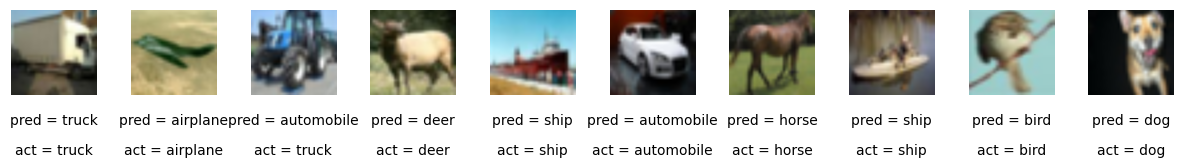

In [8]:
# 7. Predict and display results
CLASSES = np.array([
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx].numpy()
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(0.5, -0.35, "pred = " + str(preds_single[idx]), fontsize=10, ha="center", transform=ax.transAxes)
    ax.text(0.5, -0.7, "act = " + str(actual_single[idx]), fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(img)
plt.show()